In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

In [2]:
df=pd.read_csv('traffic.csv')
df.head()

,Datetime,Traffic
0,31-12-2004 01:00,135
1,31-12-2004 02:00,129
2,31-12-2004 03:00,126
3,31-12-2004 04:00,125
4,31-12-2004 05:00,127


In [3]:
df = pd.read_csv('traffic.csv', index_col='Datetime', parse_dates=['Datetime'])
df.head()

,Traffic
Datetime,
2004-12-31 01:00:00,135
2004-12-31 02:00:00,129
2004-12-31 03:00:00,126
2004-12-31 04:00:00,125
2004-12-31 05:00:00,127


In [4]:
df.isna().sum()

Traffic    0
dtype: int64

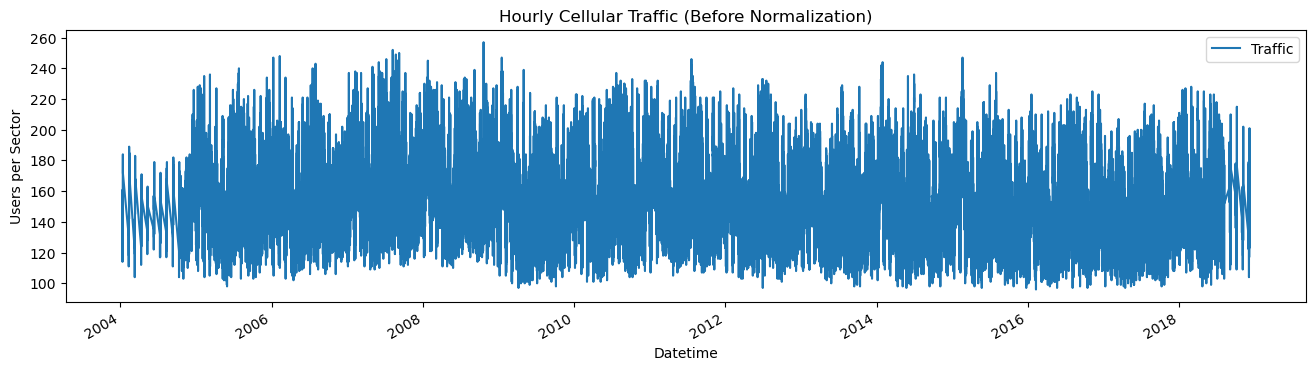

In [5]:
df.plot(figsize=(16,4),legend=True)
plt.title('Hourly Cellular Traffic (Before Normalization)')
plt.ylabel('Users per Sector')
plt.show()

In [6]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['Traffic']=scaler.fit_transform(df['Traffic'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(121273, 1)

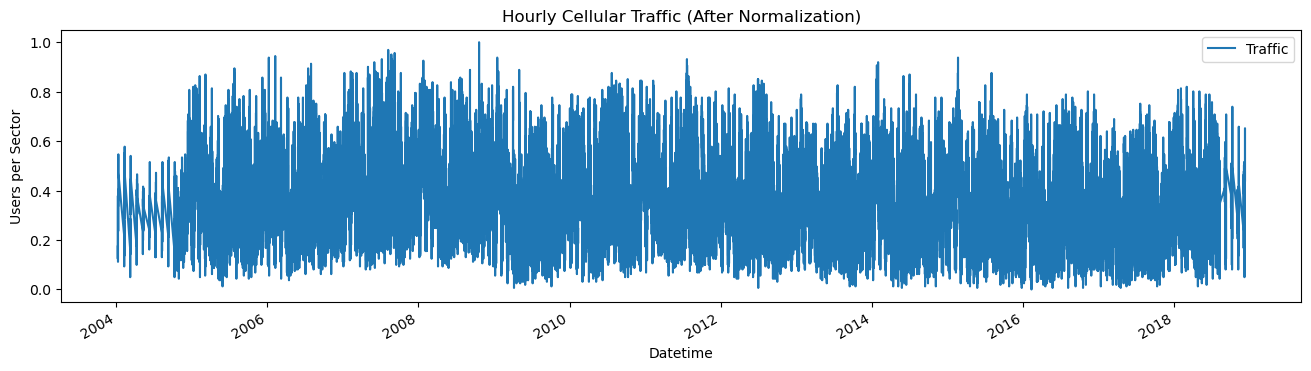

In [7]:
df_norm.plot(figsize=(16,4),legend=True)
plt.title('Hourly Cellular Traffic (After Normalization)')
plt.ylabel('Users per Sector')
plt.show()

In [8]:
df_norm.shape

(121273, 1)

In [9]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    return [X_train, y_train, X_test, y_test]

In [10]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    return [X_train, y_train, X_test, y_test]

In [11]:
#create train, test data
seq_len = 20 #choose sequence length
X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (11253, 20, 1)
y_test.shape =  (11253,)


In [12]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 dropout (Dropout)           (None, 20, 40)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 40)            3240      
                                                                 
 dropout_1 (Dropout)         (None, 20, 40)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense (Dense)               (None, 1)                 4

In [13]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=100, batch_size=1000)

Epoch 1/100
110/110 [==============================] - 10s 71ms/step - loss: 0.0972
Epoch 2/100
110/110 [==============================] - 8s 71ms/step - loss: 0.0173
Epoch 3/100
110/110 [==============================] - 8s 73ms/step - loss: 0.0095
Epoch 4/100
110/110 [==============================] - 8s 74ms/step - loss: 0.0068
Epoch 5/100
110/110 [==============================] - 8s 72ms/step - loss: 0.0054
Epoch 6/100
110/110 [==============================] - 8s 72ms/step - loss: 0.0045
Epoch 7/100
110/110 [==============================] - 8s 72ms/step - loss: 0.0039
Epoch 8/100
110/110 [==============================] - 8s 73ms/step - loss: 0.0034
Epoch 9/100
110/110 [==============================] - 8s 73ms/step - loss: 0.0031
Epoch 10/100
110/110 [==============================] - 8s 72ms/step - loss: 0.0028
Epoch 11/100
110/110 [==============================] - 8s 72ms/step - loss: 0.0026
Epoch 12/100
110/110 [==============================] - 8s 73ms/step - loss: 0.0024


110/110 [==============================] - 8s 72ms/step - loss: 8.9571e-04
Epoch 97/100
110/110 [==============================] - 8s 71ms/step - loss: 8.8977e-04
Epoch 98/100
110/110 [==============================] - 8s 71ms/step - loss: 8.9168e-04
Epoch 99/100
110/110 [==============================] - 8s 72ms/step - loss: 8.9207e-04
Epoch 100/100
110/110 [==============================] - 8s 71ms/step - loss: 8.9315e-04


In [14]:
rnn_predictions = rnn_model.predict(X_test)
rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

352/352 [==============================] - 1s 3ms/step
R2 Score of RNN model =  0.9741003460768142


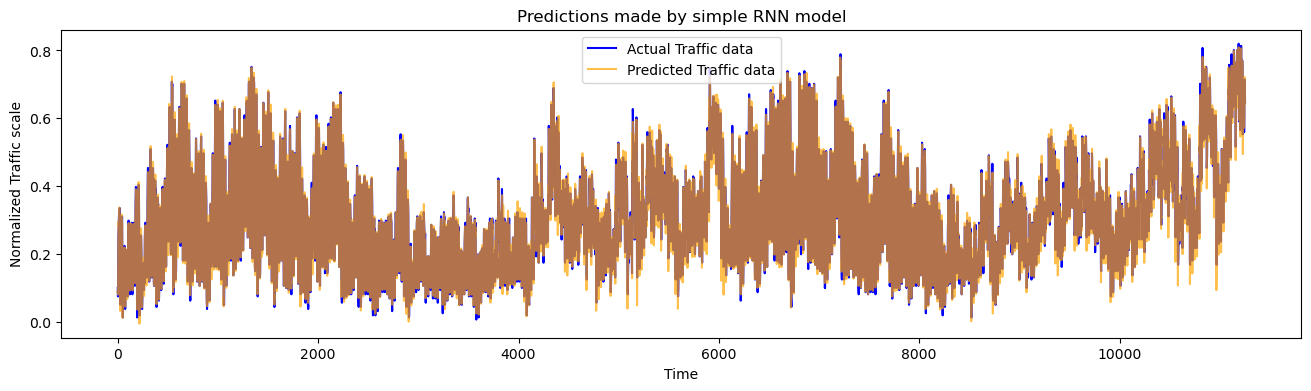

In [16]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual Traffic data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted Traffic data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized Traffic scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

In [17]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 40)            6720      
                                                                 
 dropout_3 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 40)            12960     
                                                                 
 dropout_4 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [18]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=100, batch_size=1000)

Epoch 1/100
110/110 [==============================] - 31s 252ms/step - loss: 0.0252
Epoch 2/100
110/110 [==============================] - 33s 300ms/step - loss: 0.0130
Epoch 3/100
110/110 [==============================] - 30s 273ms/step - loss: 0.0058
Epoch 4/100
110/110 [==============================] - 34s 311ms/step - loss: 0.0035
Epoch 5/100
110/110 [==============================] - 33s 299ms/step - loss: 0.0026
Epoch 6/100
110/110 [==============================] - 32s 295ms/step - loss: 0.0023
Epoch 7/100
110/110 [==============================] - 33s 297ms/step - loss: 0.0021
Epoch 8/100
110/110 [==============================] - 33s 297ms/step - loss: 0.0020
Epoch 9/100
110/110 [==============================] - 34s 305ms/step - loss: 0.0019
Epoch 10/100
110/110 [==============================] - 33s 301ms/step - loss: 0.0018
Epoch 11/100
110/110 [==============================] - 34s 304ms/step - loss: 0.0017
Epoch 12/100
110/110 [==============================] - 34s 307

110/110 [==============================] - 20s 181ms/step - loss: 6.8148e-04
Epoch 94/100
110/110 [==============================] - 20s 181ms/step - loss: 6.8459e-04
Epoch 95/100
110/110 [==============================] - 20s 182ms/step - loss: 6.9025e-04
Epoch 96/100
110/110 [==============================] - 20s 184ms/step - loss: 6.7742e-04
Epoch 97/100
110/110 [==============================] - 20s 184ms/step - loss: 6.7364e-04
Epoch 98/100
110/110 [==============================] - 20s 184ms/step - loss: 6.7035e-04
Epoch 99/100
110/110 [==============================] - 20s 184ms/step - loss: 6.6530e-04
Epoch 100/100
110/110 [==============================] - 20s 185ms/step - loss: 6.7339e-04


In [20]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

352/352 [==============================] - 3s 6ms/step
R^2 Score of LSTM model =  0.9810959180419356


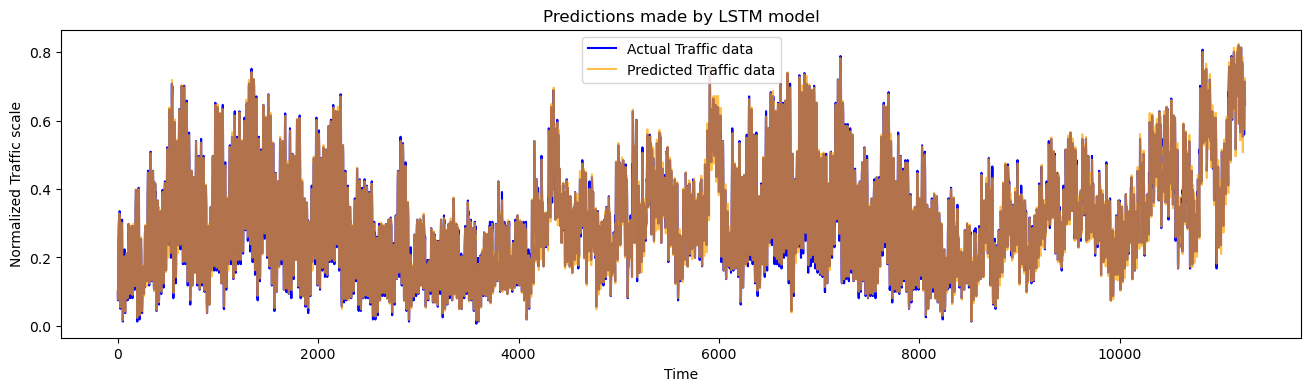

In [21]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

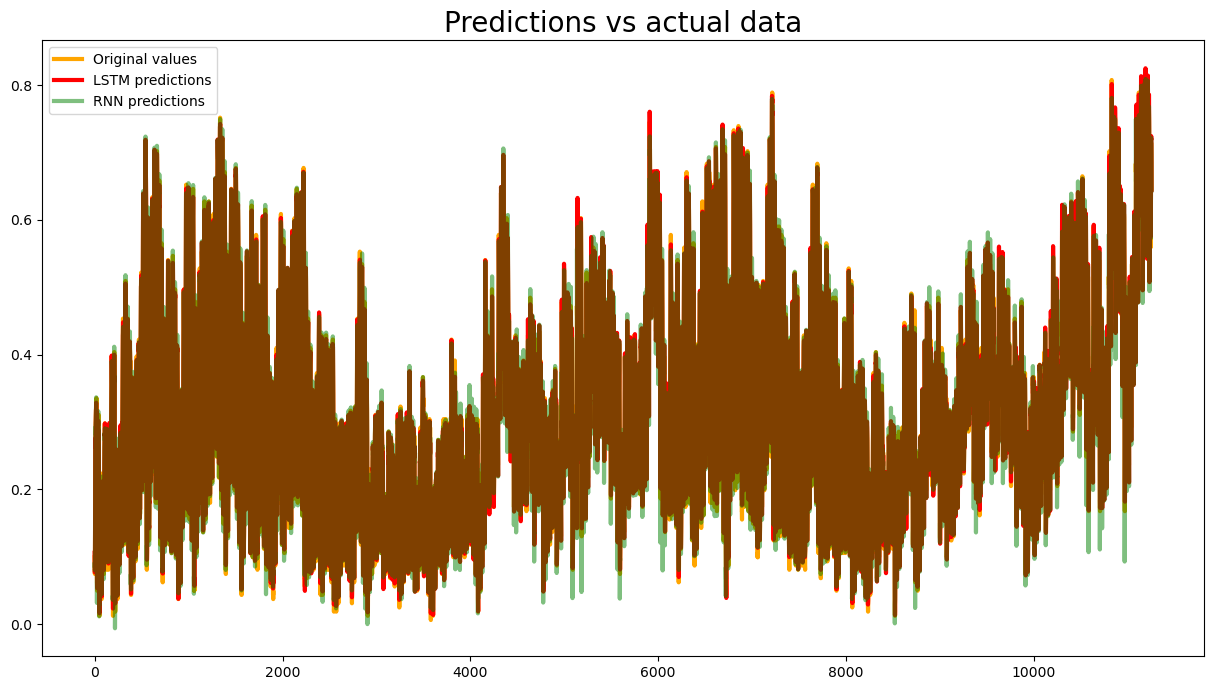

In [22]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()